<a href="https://colab.research.google.com/github/ctate7163/radiometry/blob/main/radiometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Radiometry for exposure time calculation

This notebook estimates the camera design requirements

All quantities are in SI units unless stated otherwise.

Symbols used below.

| Symbol | Name | SI units | Note |
| :-- | ------ | :----- | ------ |
| Q$_e$ | radiant energy | J |  |
| 𝛷$_e$ | radiant flux | W |  |
| I$_e$$_Ω$ | radiant intensity | W/sr |  |
| L$_e$$_Ω$ | radiance | W/sr/m$^2$ |  |
| E$_e$ | irradiance | W/m$^2$ | also flux density |
| M$_e$ | exitance | W/m$^2$ | also emittance |
| Ω | solid angle | sr |  |
| λ | wavelength | meters |  |
| α | albedo |  - | also reflectance |
| T | transmission | - |  |
| S | signal | e$^-$ | detector signal in electrons |
| t | exposure time | sec |  |
| r | radius | m |  |
| d | distance | m |  |
| l | length | m |  |
| A | area | m$^2$ |  |
| QE | quantum efficency | e$^-$/photon |  |
| i | incidence | rad |  |
|  |  |  |  |

See Wikipedia [here](https://en.wikipedia.org/wiki/Radiometry) for notation conventions

Solar spectrum is the E-490-00 standard downloaded from [here](https://www.nrel.gov/grid/solar-resource/spectra-astm-e490.html)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
# from astropy.table import Table
# import astropy.units as u

In [6]:
!pip install PySpectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 31.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 64.1 MB/s eta 0:00:00
  Created wheel for PySpectral: filename=pyspectral-0.13.5-py2.py3-none-any.whl size=702045 sha256=cd5e8488e91937265c097115a6d693a1f6ba9db158149957b25a345716b55dd4
  Stored in directory: /root/.cache/pip/wheels/f7/ab/97/aaee93364f115f1dbed177408b70128ea4af99d8c04e9a3600
Successfully built PySpectral


In [19]:
l_min  = 200e-9
l_max  = 1200e-9
l_bin  = 10e-9

l = np.arange(l_min,l_max,l_bin)

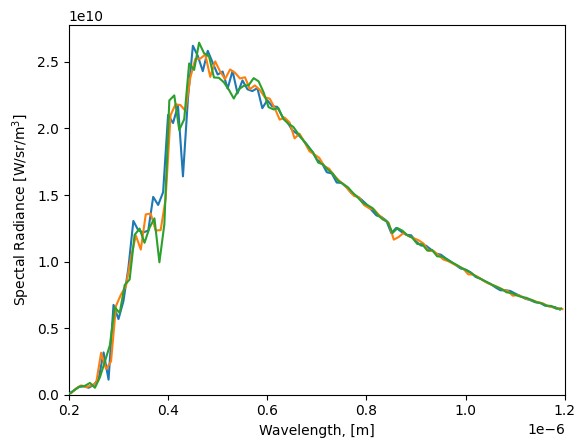

In [42]:

# Get Solar radiance at 1 AU

from pyspectral.solar import SolarIrradianceSpectrum
solar_irr = SolarIrradianceSpectrum()

l_ = solar_irr.wavelength/1e6
E_ = solar_irr.irradiance*1e6
L_ = E_*4*np.pi

# E = new_irradiance( l_, E_, np.arange(l_min-l_bin/2,l_max+l_bin/2,l_bin) )
# L = new_irradiance( l_, L_, np.arange(l_min-l_bin/2,l_max+l_bin/2,l_bin) )

E = np.interp(l,l_,E_)
L = np.interp(l,l_,L_)

plt.plot(l, L, zorder=10)
# plt.plot(l_,L_)

E = np.interp(l+l_bin/2,l_,E_)
L = np.interp(l+l_bin/2,l_,L_)
plt.plot(l+l_bin/2, L, zorder=10)

E = np.interp(l+l_bin/2,l_,E_)
L = np.interp(l+l_bin/4,l_,L_)
plt.plot(l+l_bin/4, L, zorder=10)



plt.xlabel('Wavelength, [m]')
plt.ylabel('Spectal Radiance [W/sr/m$^3$]')
plt.xlim([l_min,l_max])
plt.ylim(bottom=0)
plt.show()


In [21]:
from scipy.stats import binned_statistic

def new_irradiance(wavelength, irradiance, new_wavelength):
    wavelength = np.array(wavelength)
    irradiance = np.array(irradiance)

    # Define bin edges spanning the range of the data.
    bins = new_wavelength

    # Use binned_statistic to compute the mean irradiance per bin.
    stat, bin_edges, _ = binned_statistic(wavelength, irradiance, statistic='mean', bins=bins)

    # Compute bin centers from bin edges.
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    return bin_centers

# New Section

In [24]:
len(E), len(l)

(99, 100)